In [1]:
from __future__ import print_function, division

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess
from climlab.utils import heat_capacity
from matplotlib.pyplot import cm


from IPython.display import HTML


import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings

import util
import ram_model
import plotting

## Data

Read data and concatenate into one dataset.

level 0 = Surface

level 110 = TOA

(our data is in the order TOA-->Surface)

In [3]:
ds = util.load_soundings()
util.add_monthly_insolation(ds)
ds = util.adjust_lev(ds, nlevels = 95)

Dropped levels [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 17, 18, 20, 22, 24, 26]


# Climlab

All tendencies must be in K/sec (see Climlab energy_budget documentation and self.heating_rate attribute): https://climlab.readthedocs.io/en/latest/_modules/climlab/process/energy_budget.html#EnergyBudget

In [136]:
#### Find the surface diffk average over 12 months at CO2 = .00038 ####
timestep = 3600 #seconds
ram_dict_annual_mean_diffk = {}
ram_dict_annual_mean_diffk = ram_model.fill_ensemble(ds, ram_dict_annual_mean_diffk, timestep, advection = None, surface_diffk = None)
surface_diffk_average = ram_model.annual_mean_sfc_diffk(ds, ram_dict_annual_mean_diffk)

/Users/lyssafreese/Documents/code/antarctic_rad/notebooks/ram_model.py:114: UserWarning: CFL Condition not met, [1.24807274], timestep too large or lower level z difference too small for January, CO2 kg/kg
  warnings.warn(f"CFL Condition not met, {self._CFL}, timestep too large or lower level z difference too small for {self.m}, CO2 kg/kg")


In [137]:
#### Find our initial output for the model with a set average surface diffk #### 
ram_dict = {}
ram_dict = ram_model.fill_ensemble(ds, ram_dict, timestep, advection = None, surface_diffk = surface_diffk_average)
advection_380_monthly = {}
for m in ram_dict[0.00038].keys():
    advection_380_monthly[m] = ram_dict[0.00038][m].subprocess.Advection.forcing_tendencies['Tatm']

In [138]:
surface_diffk_average

Field([0.35573846])

In [139]:
#### Find our initial output for the model with a set average surface diffk #### 
ram_dict = {}
ram_dict = ram_model.fill_ensemble(ds, ram_dict, timestep, advection = advection_380_monthly, surface_diffk = surface_diffk_average)

# Output (initial and over time)

### Initial

In [140]:
###set up lists and variables
diagnostics_list = list(ram_dict[.0001]['January'].diagnostics.keys())
temp_list = ['Ts','Tatm']
adv_dict = {'advection_Ts':'Ts','advection_Tatm':'Tatm'}
output_list = temp_list + diagnostics_list + list(adv_dict.keys()) + ['lev_bounds'] + ['time']
print('Outputs available ' + str(output_list))
print('CO2 values ' + str(ds['CO2_list'].values))
print('timestep ' + str(timestep) + ' seconds')


Outputs available ['Ts', 'Tatm', 'OLR', 'OLRclr', 'OLRcld', 'TdotLW', 'TdotLW_clr', 'LW_sfc', 'LW_sfc_clr', 'LW_flux_up', 'LW_flux_down', 'LW_flux_net', 'LW_flux_up_clr', 'LW_flux_down_clr', 'LW_flux_net_clr', 'ASR', 'ASRclr', 'ASRcld', 'TdotSW', 'TdotSW_clr', 'SW_sfc', 'SW_sfc_clr', 'SW_flux_up', 'SW_flux_down', 'SW_flux_net', 'SW_flux_up_clr', 'SW_flux_down_clr', 'SW_flux_net_clr', 'total_sfc_flux_init', 'total_sfc_flux', 'theta_init', 'dtheta_dz_surf_init', 'surface_diffk', 'theta', 'dtheta_dz', 'atm_diffk', 'atm_turbulent_flux', 'sfc_turbulent_flux', 'turb_atm_hr', 'turb_sfc_hr', 'turb_hr', 'z', 'z_bounds', 'advection_Ts', 'advection_Tatm', 'lev_bounds', 'time']
CO2 values [0.      0.0001  0.0002  0.00038 0.00076 0.001   0.0015 ]
timestep 3600 seconds


In [141]:
### create dictionary for results
results_dict = {}

In [142]:
### results at first timestep
results_dict[0] = {}
for output in output_list:
    results_dict[0][output] = {}
    for CO2 in ds['CO2_list'].values:
        results_dict[0][output][CO2] = {}
        for m in np.asarray(ds['month']):
            results_dict[0][output][CO2][m] = {}
            if output in (diagnostics_list):
                results_dict[0][output][CO2][m] = (ram_dict[CO2][m].diagnostics[output])
            if output in temp_list:
                results_dict[0][output][CO2][m] = list(ram_dict[CO2][m].state[output])
            if output in list(adv_dict.keys()):
                results_dict[0][output][CO2][m] = list(ram_dict[CO2][m].subprocess.Advection.forcing_tendencies[adv_dict[output]])
            if output == 'lev_bounds':
                results_dict[0][output][CO2][m] = list(ram_dict[CO2][m].lev_bounds)
            if output == 'time':
                results_dict[0]['time'][CO2][m] = list(ram_dict[CO2][m].time)

### Initial condition plots

Temperature

OLR

Surface LW and net radiation

GHE at different CO2 concentrations

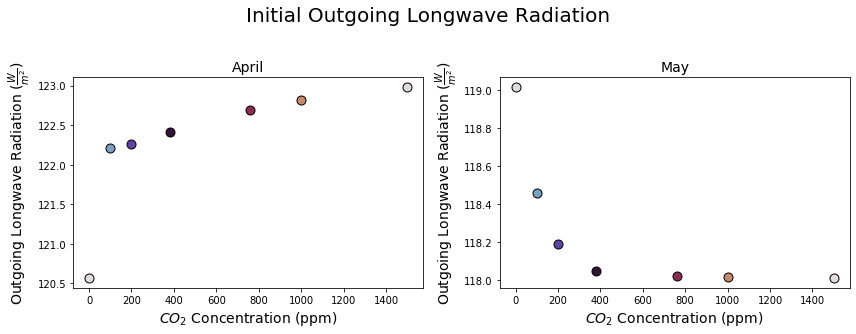

In [35]:
#plot OLR
plotting.plot_sfc_TOA_process(ds, results_dict, 'OLR', ['April', 'May'], single_level_process)
plt.suptitle('Initial Outgoing Longwave Radiation', fontsize = 20, y = 1.15);
#plt.savefig('../figures/OLR_init.png', bbox_inches = 'tight', dpi = 150)

/Users/lyssafreese/Documents/code/antarctic_rad/notebooks/plotting.py:241: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


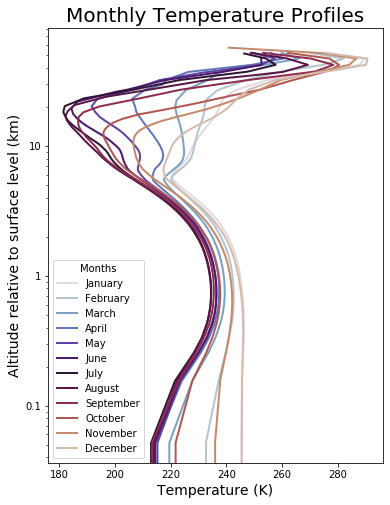

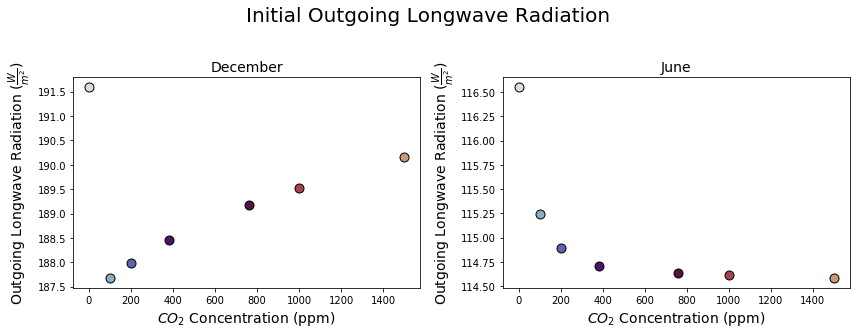

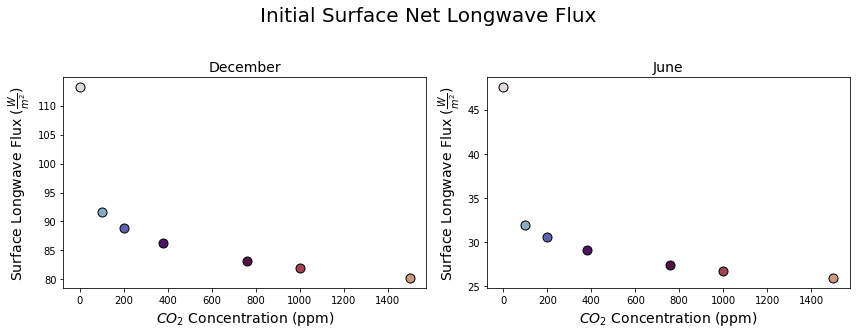

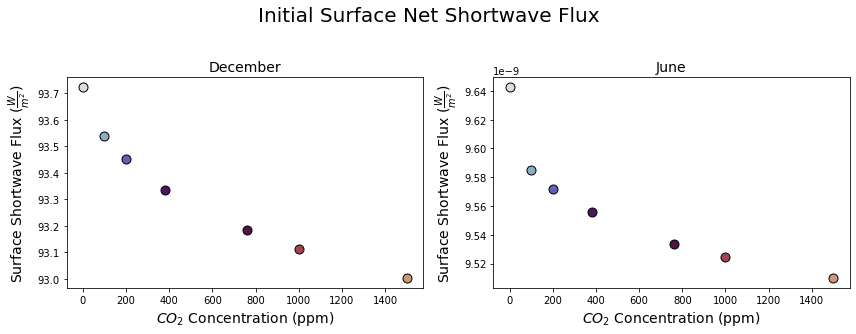

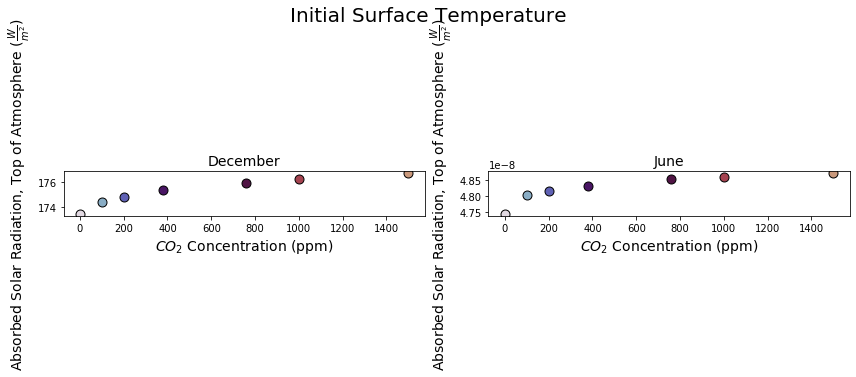

In [118]:
#plot temperature profiles
plotting.plot_temp(ds, results_dict)
plt.savefig('../figures/initial_temperature_profiles.png', bbox_inches = 'tight', dpi = 150)

#plot OLR
plotting.plot_sfc_TOA_process(ds, results_dict, 'OLR', ['December','June'], single_level_process)
plt.suptitle('Initial Outgoing Longwave Radiation', fontsize = 20, y = 1.15);
plt.savefig('../figures/OLR_init.png', bbox_inches = 'tight', dpi = 150)

#plot LW surface flux
plotting.plot_sfc_TOA_process(ds, results_dict, 'LW_sfc_clr', ['December','June'], single_level_process)
plt.suptitle('Initial Surface Net Longwave Flux', fontsize = 20, y = 1.15);
plt.savefig('../figures/sfcLW_init.png', bbox_inches = 'tight', dpi = 150)

#plot SW surface flux
plotting.plot_sfc_TOA_process(ds, results_dict, 'SW_sfc_clr', ['December','June'], single_level_process)
plt.suptitle('Initial Surface Net Shortwave Flux', fontsize = 20, y = 1.15);
plt.savefig('../figures/sfcSW_init.png', bbox_inches = 'tight', dpi = 150)

#plot initial Ts
plotting.plot_sfc_TOA_process(ds, results_dict, 'ASRclr', ['December','June'], single_level_process)
plt.suptitle('Initial Surface Temperature', fontsize = 20, y = 1.15);


In [72]:
#GHE = SFC(lw,up) - OLR
GHE = {}
for m in np.asarray(ds['month']):
    GHE[m] = {}
    for CO2 in ds['CO2_list'].values:
        GHE[m][CO2] = {}
        GHE[m][CO2] = results_dict[0]['OLR'][0][m][-1] - results_dict[0]['OLR'][CO2][m]

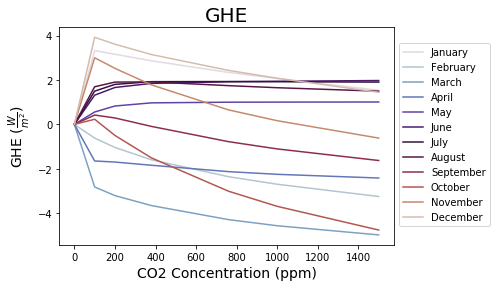

In [161]:
fig, ax = plt.subplots(figsize = [6,4])
color=iter(cm.twilight(np.linspace(0,1,13)))
for month in GHE.keys():
    c = next(color)
    plt.plot(np.asarray(list(GHE[month].keys()))*1e6, list(GHE[month].values()), c=c, label = month)
    plt.legend()
    plt.title('GHE', fontsize = 20)
    plt.ylabel(r'GHE $(\frac{W}{m^2})$', fontsize = 14)
    plt.xlabel('CO2 Concentration (ppm)', fontsize = 14)
    plt.legend(bbox_to_anchor=(1.0, .95))
plt.savefig('../figures/GHE.png', bbox_inches = 'tight',dpi = 150)

### Timestep forward

In [143]:
steps = 3650
### results for each timestep
for i in range(steps):
    #step model forward
    results_dict[(i+1)*timestep] = {}
    for count, output in enumerate(output_list):
        results_dict[(i+1)*timestep][output] = {}
        for CO2 in ds['CO2_list'].values:
            results_dict[(i+1)*timestep][output][CO2] = {}
            for m in np.asarray(ds['month']):
                results_dict[(i+1)*timestep][output][CO2][m] = {}
                if count==0:
                    ram_dict[CO2][m].step_forward()
                #add outputs/diagnostics
                if output in (diagnostics_list):
                    results_dict[(i+1)*timestep][output][CO2][m] = (ram_dict[CO2][m].diagnostics[output])
                if output in temp_list:
                    results_dict[(i+1)*timestep][output][CO2][m] = list(ram_dict[CO2][m].state[output])
                if output in list(adv_dict.keys()):
                    results_dict[(i+1)*timestep][output][CO2][m] = list(ram_dict[CO2][m].subprocess.Advection.forcing_tendencies[adv_dict[output]])
                if output == 'lev_bounds':
                    results_dict[(i+1)*timestep][output][CO2][m] = list(ram_dict[CO2][m].lev_bounds)

#### parameters for plots

In [144]:
###select CO2 concentrations and times to look at
CO2_conc1 = .00038
CO2_conc2 = .00076
time1 = (0)*timestep
time2 = 365*timestep
time3 = 730*timestep
time4 = 1460*timestep
time5 = 2190*timestep
time6 = 2920*timestep
time7 = 3650*timestep
month1 = 'December'
month2 = 'June'

###create a dict of output names and the z bounds they align with
output_dict = {}
output_dict['bounds'] = {'Tatm':'z','TdotLW_clr':'z', 'LW_flux_up_clr':'z_bounds', 
               'LW_flux_down_clr':'z_bounds', 'LW_flux_net_clr':'z_bounds', 
               'TdotSW_clr':'z', 'SW_flux_up_clr':'z_bounds', 
               'SW_flux_down_clr':'z_bounds', 'SW_flux_net_clr':'z_bounds',
               'theta_init':'z', 'theta':'z', 'dtheta_dz':'z_bounds', 'atm_diffk':'z_bounds', 
               'atm_turbulent_flux':'z_bounds','turb_atm_hr':'z', 
               'turb_hr':'z', 'advection_Tatm':'z'}
atm_process_dict = {'Tatm':'Atmospheric Temperature (K)',
                    'atm_diffk':r'Atmospheric $\kappa$ ($\frac{m^2}{s}$)',
                    'dtheta_dz':r'$\frac{d\theta}{dz}$ ($\frac{K}{m}$)',
                    'theta':r'$\theta$',
                    'SW_flux_net_clr':r'Shortwave Flux ($\frac{W}{m^2}$)',
                    'LW_flux_net_clr':r'Longwave Flux ($\frac{W}{m^2}$)', 
                    'TdotLW_clr':r'Longwave Heating Rate ($\frac{K}{s}$)',
                    'TdotSW_clr':r'Shortwave Heating Rate ($\frac{K}{s}$)',
                    'turb_atm_hr':r'Turbulent Heating Rate ($\frac{K}{s}$)',
                    'advection_Tatm':r'Advective Heating Rate ($\frac{K}{s}$)',
                   'atm_turbulent_flux':'Turbulent Flux'}
single_level_process = {'LW_sfc_clr':r'Surface Longwave Flux ($\frac{W}{m^2}$)', 
                        'Ts': 'Surface Temperature (K)', 
                        'ASRclr':r'Absorbed Solar Radiation, ($\frac{W}{m^2}$)', 
                        'SW_sfc_clr':r'Surface Shortwave Flux ($\frac{W}{m^2}$)', 
                        'total_sfc_flux':r'Total Surface Flux ($\frac{W}{m^2}$)', 
                        'dtheta_dz_near_surf_init':r'$\frac{d\theta}{dz}$ ($\frac{K}{m}$)', 
                        'surface_diffk':r'Surface $\kappa$ ($\frac{m^2}{s}$)', 
                        'sfc_turbulent_flux':r'Surface Turbulent Flux ($\frac{W}{m^2}$)', 
                        'turb_sfc_hr':r'Surface Turbulent Heating Rate ($\frac{K}{s}$)', 
                        'advection_Ts':r'Surface Advection ($\frac{K}{s}$)', 
                        'OLR':r'Outgoing Longwave Radiation ($\frac{W}{m^2}$)'}

In [145]:
np.asarray(results_dict[time7]['Ts'][0.00076]['December']) - np.asarray(results_dict[time7]['Ts'][0.00038]['December'])

array([1.48400214])

In [146]:
np.asarray(results_dict[time7]['Ts'][0.00076]['June']) - np.asarray(results_dict[time7]['Ts'][0.00038]['June'])

array([1.11354706])

#### CO2 difference plots

['atm_diffk','Tatm','dtheta_dz','theta','SW_flux_net_clr','LW_flux_net_clr','TdotLW_clr','TdotSW_clr','turb_atm_hr','advection_Tatm']

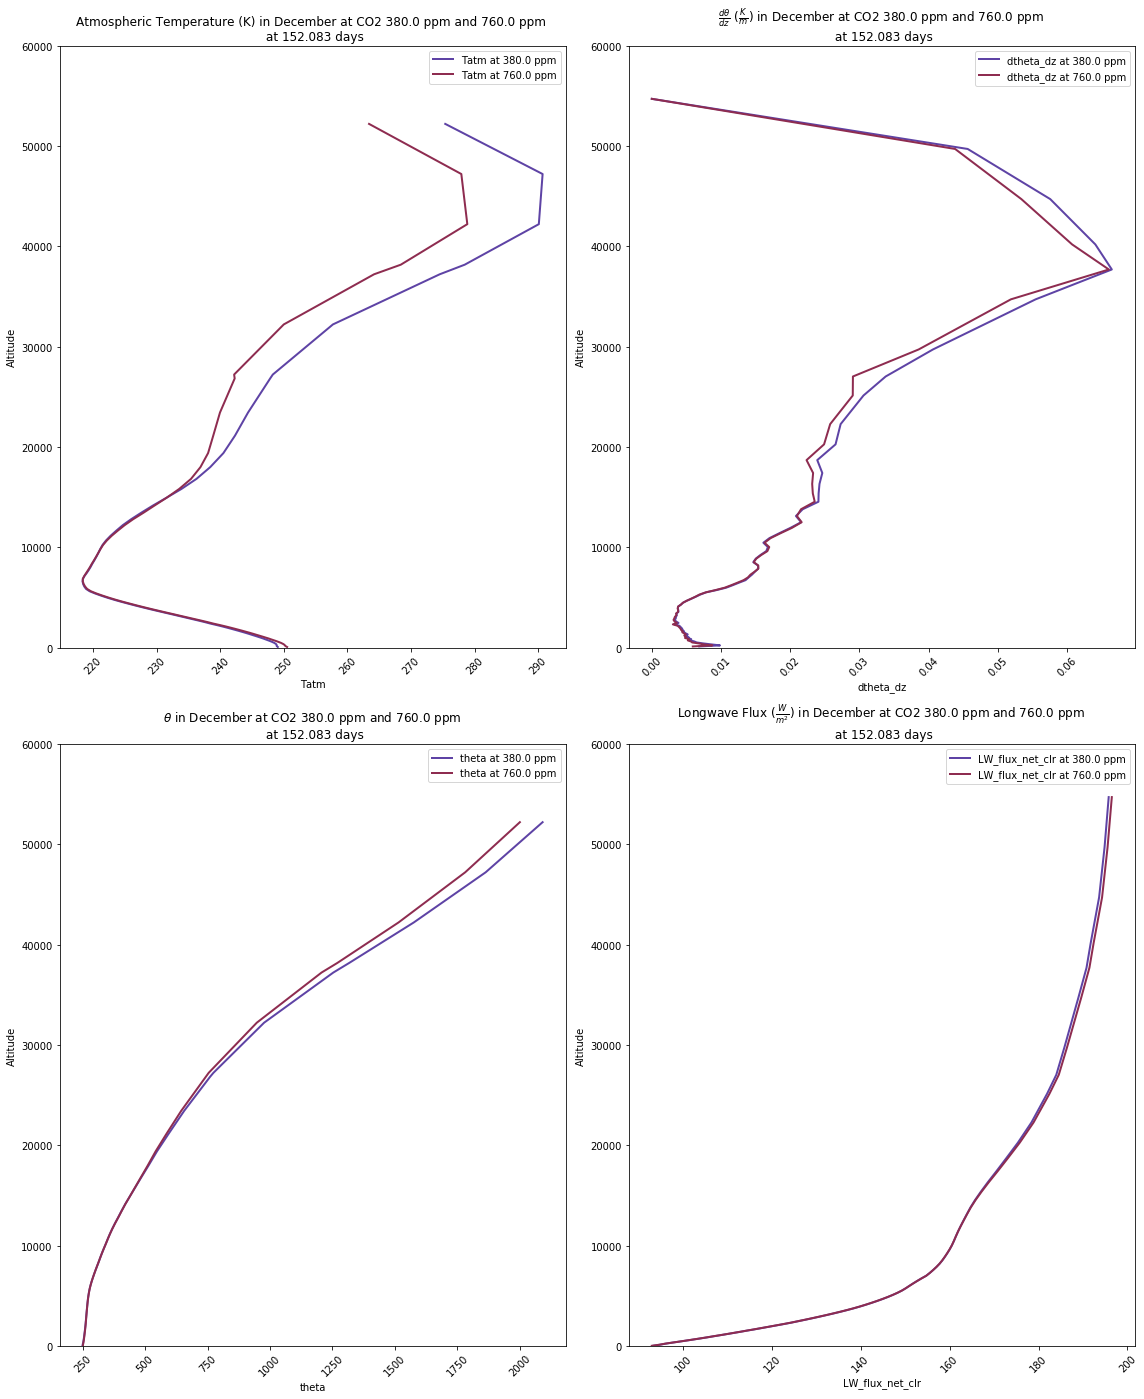

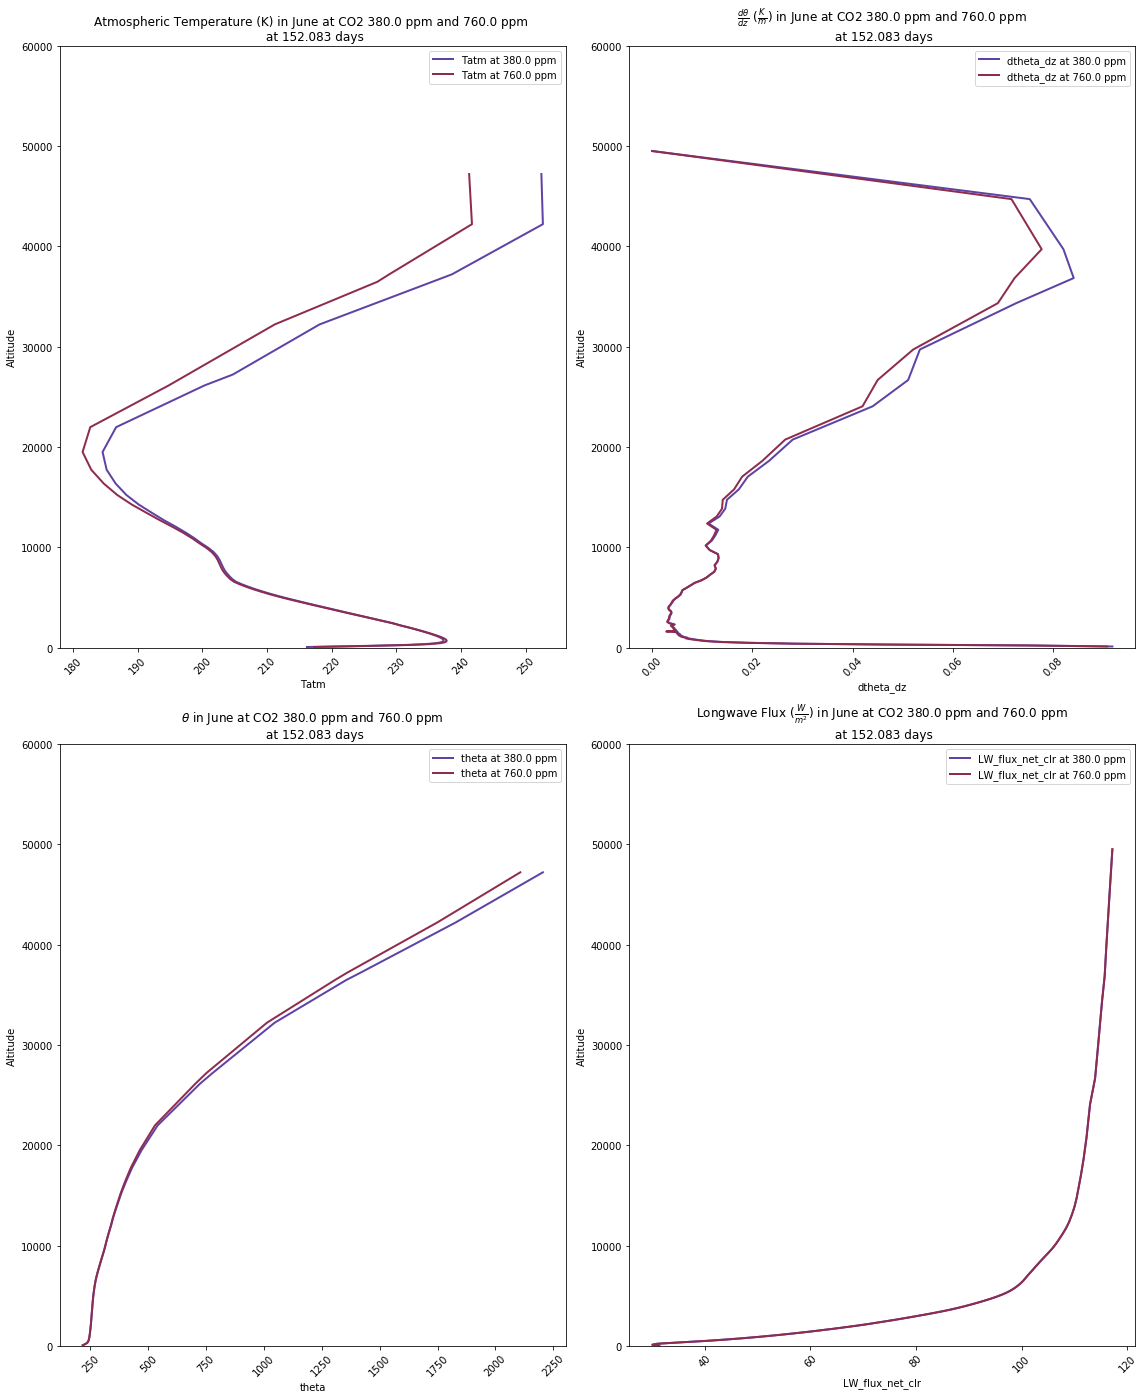

In [147]:
for month in [month1, month2]:
    plotting.plot_co2_dif(
        results_dict, 
        outputs = ['Tatm','dtheta_dz','theta','LW_flux_net_clr'],
        output_dict = output_dict, CO2_conc1 = CO2_conc1,CO2_conc2 = CO2_conc2, 
        time1 = time7, month = month ,figsize = [16,48], rows =5, columns =2, ylim = 60000, diff_only = False
    )
#plt.savefig(f'../figures/{month}_dif_only_CO2_1000m.png', bbox_inches = 'tight', dpi = 150)

#### time difference plots

['Tatm','atm_diffk','dtheta_dz','theta','SW_flux_net_clr','LW_flux_net_clr','TdotLW_clr','TdotSW_clr','turb_atm_hr','advection_Tatm', 'atm_turbulent_flux']:


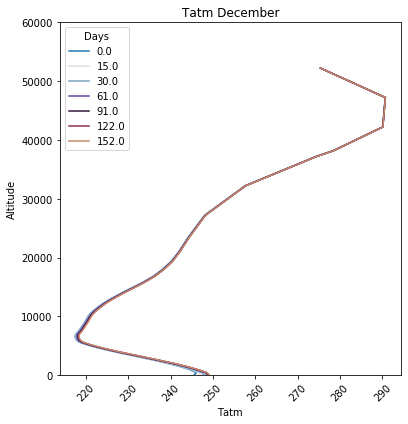

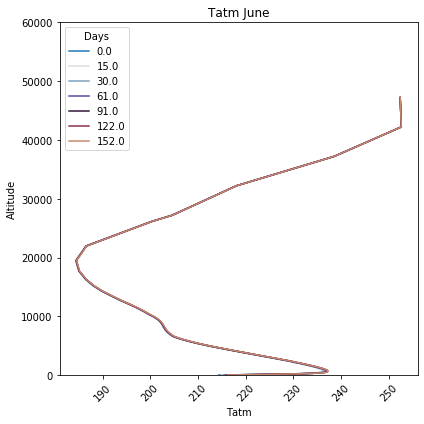

In [148]:
for output in ['Tatm']:
    for month in [month1, month2]:
        plotting.plot_time_dif(
            results_dict,
            output = output,
            output_dict = output_dict, CO2_conc1 = CO2_conc1, time1 = 0, timesteps = [time2, time3, time4, time5, time6, time7], month = month,
            figsize = [6,6], ylim = 60000, diff_only = False
                               )
        plt.title(f'{output} {month}')
#plt.savefig(f'../figures/{month}_time_dif_1000m.png', bbox_inches = 'tight', dpi = 150)

#### look at Tatm lowest level - Ts 

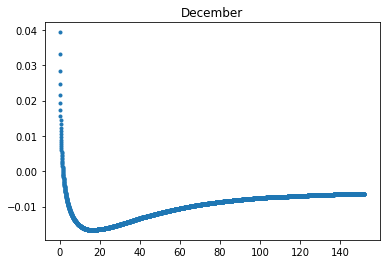

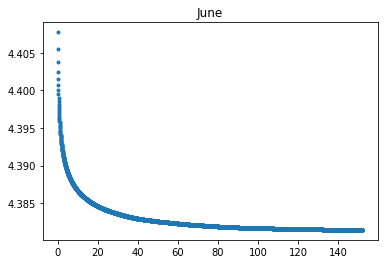

In [149]:
for month in [month1, month2]:
    fig, ax = plt.subplots()
    for idx, time in enumerate(range(0,steps*timestep, timestep)):
        plt.plot(np.round(idx*timestep/climlab.constants.seconds_per_day, 2), results_dict[time]['Tatm'][CO2_conc1][month][-1] - results_dict[time]['Ts'][CO2_conc1][month][-1], 'C0.')
    plt.title(f'{month}')

#### single level process plots: 

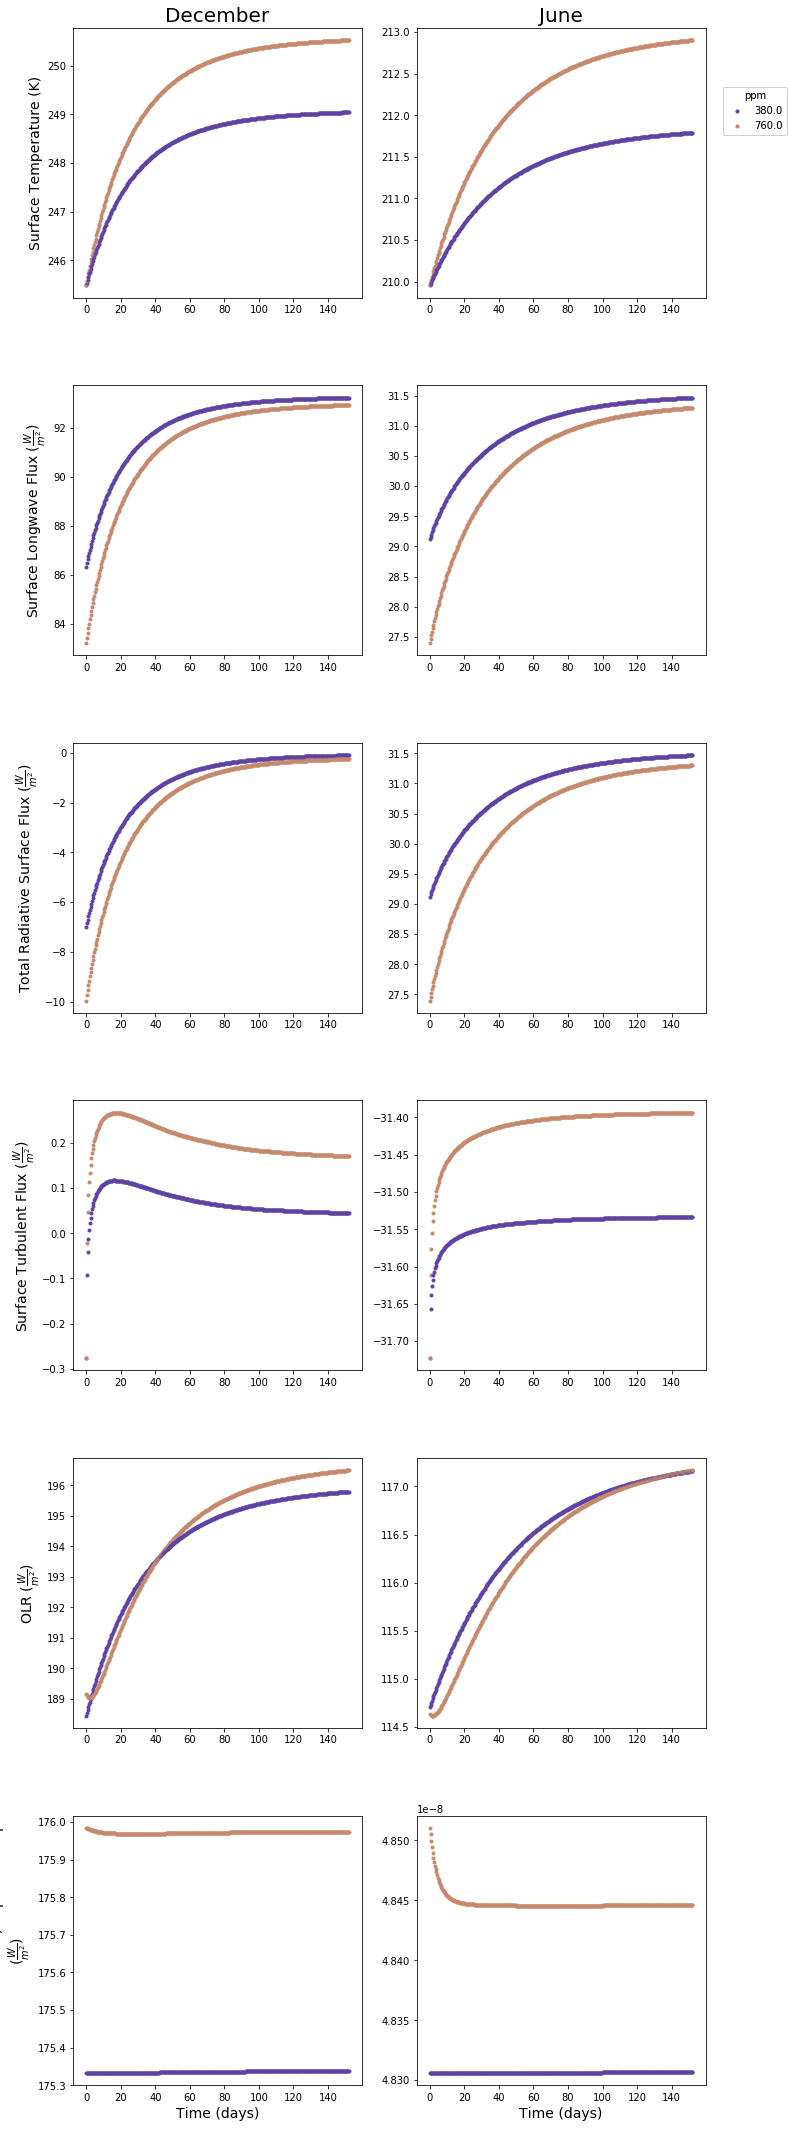

In [150]:
plotting.single_level_plot(results_dict,['Ts','LW_sfc_clr', 'total_sfc_flux', 'sfc_turbulent_flux', 'OLR', 'ASRclr'], 
                           CO2_conc1, CO2_conc2, [month1,month2], figsize = [10,30])
plt.savefig(f'../figures/surface_processes.png', bbox_inches = 'tight', dpi = 150)

KeyError: 7920000

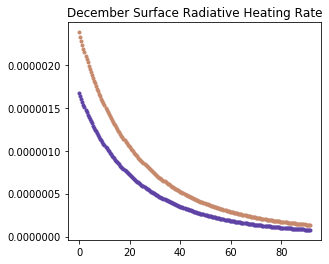

In [151]:
plotting.rad_sfc_HR_plot(rad_sfc_HR,results_dict, .00038, .00076, ['December','June'], [10,4])

In [125]:
results_dict[time7]['turb_sfc_hr'][0.00038]['December'] - rad_sfc_HR[time7][0.00038]['December']

array([6.39298886e-08])

In [126]:
results_dict[time7]['turb_sfc_hr'][0.00038]['June'] - rad_sfc_HR[time7][0.00038]['June']

array([5.75642342e-08])

#### plot entire column (surface + atmosphere)

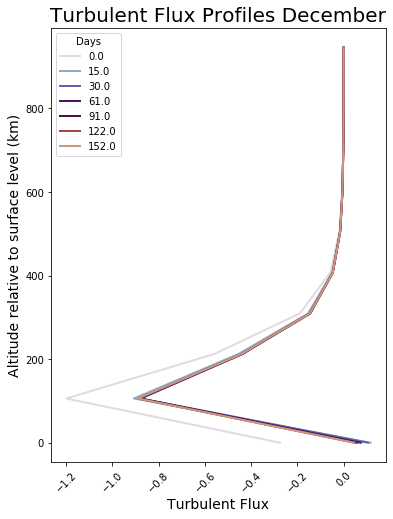

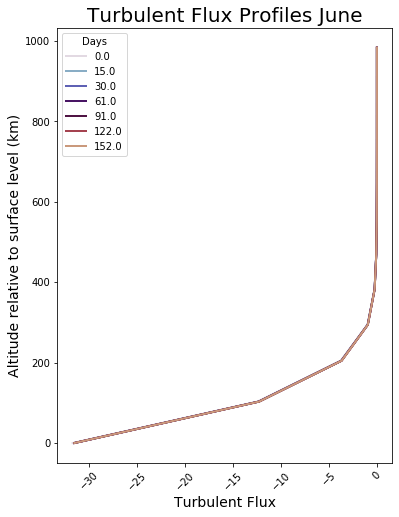

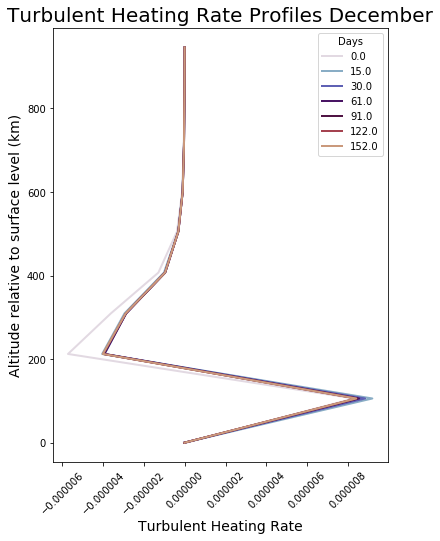

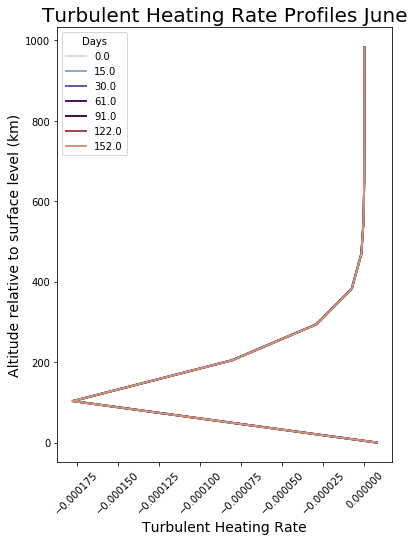

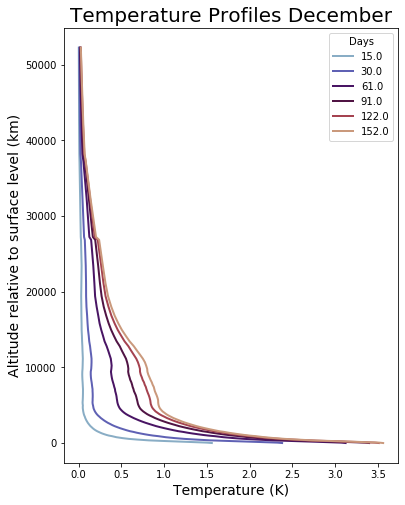

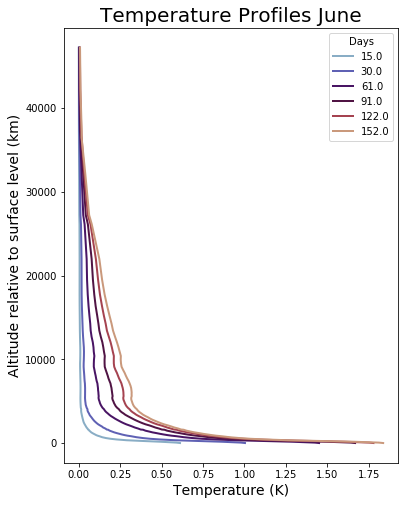

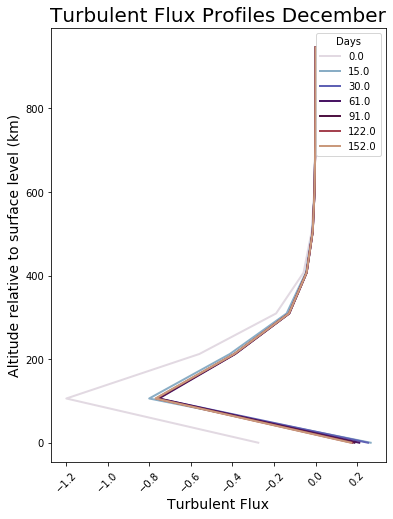

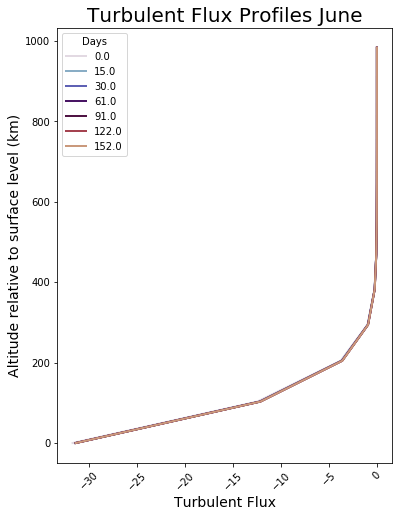

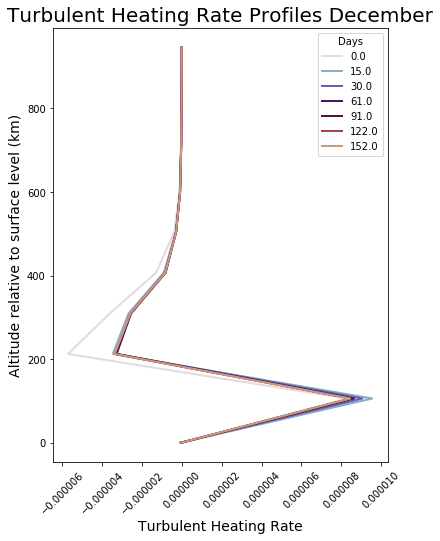

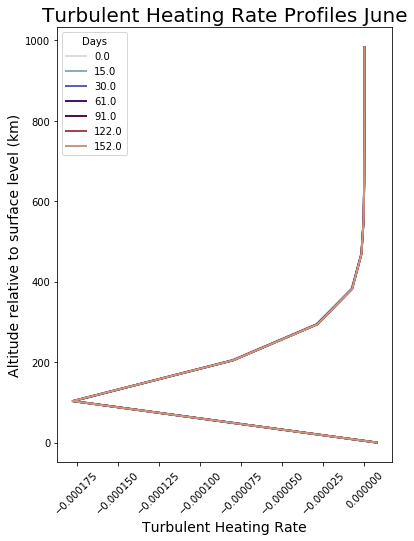

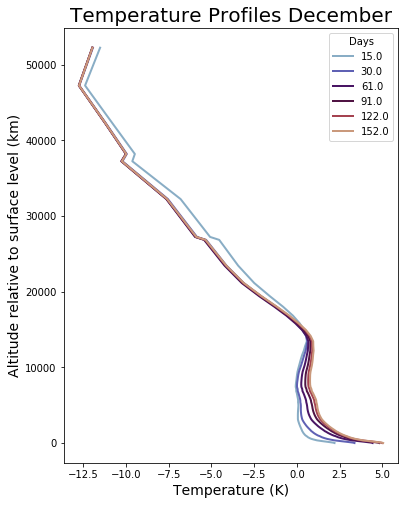

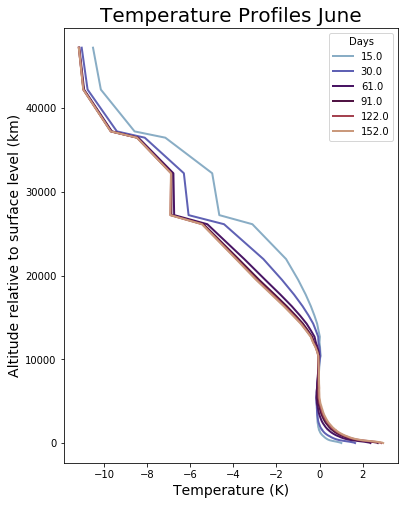

In [153]:
for CO2 in [.00038, .00076]:
    for month in [month1,month2]:
        plotting.plot_turbulent_flux(ds, results_dict, month, CO2, [time1, time2, time3, time4, time5, time6, time7], ylim = 1000)
    for month in [month1,month2]:  
        plotting.plot_turbulent_hr(ds, results_dict, month, CO2, [time1, time2, time3, time4, time5, time6, time7], ylim = 1000)
    for month in [month1,month2]:   
        plotting.plot_temp_timestepped(ds, results_dict, month, CO2, time1, [time2, time3, time4, time5, time6, time7], ylim = 60000, diff_only = True)
        plt.savefig(f'../figures/{month}_temp_{CO2}.png', bbox_inches = 'tight', dpi = 150)

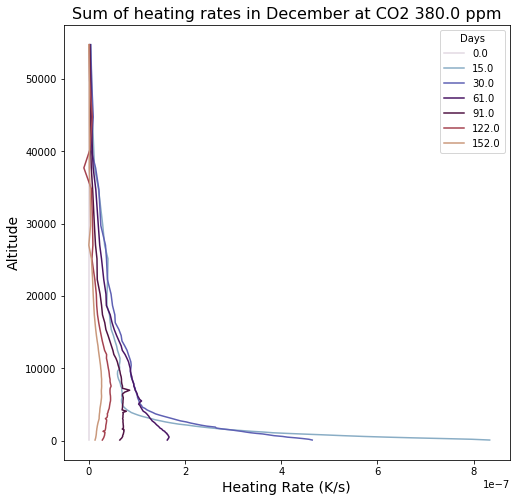

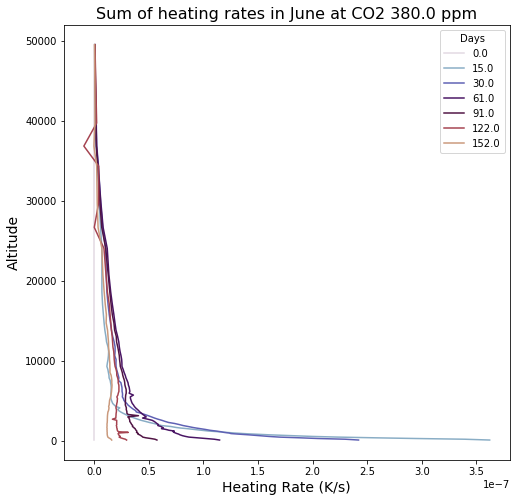

In [154]:
for month in [month1,month2]:
    plotting.plot_sum_hr(results_dict, month, .00038,[time1, time2, time3, time4, time5, time6, time7])

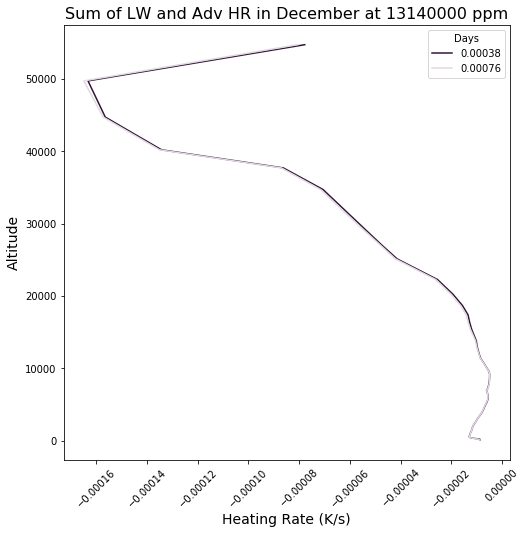

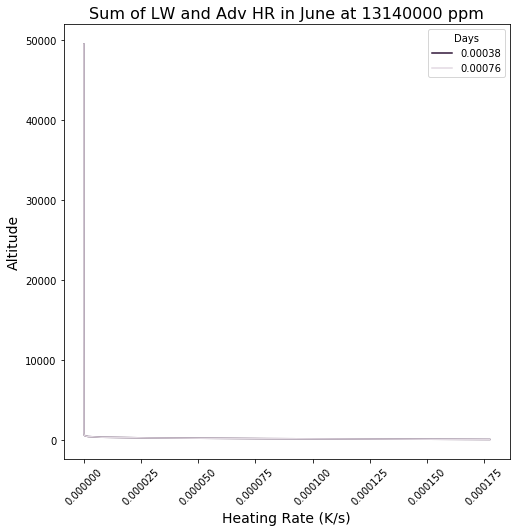

In [155]:
for month in [month1,month2]:
    plotting.plot_adv_LW_hr(results_dict, month, .00038, .00076, time7, diff_only =False)

### find entire column energy balance

In [156]:
#time we're looking at
time = time7
month = month2
#TOA Frad
F_rad_toa = np.asarray(results_dict[time]['OLR'][CO2_conc1][month]) - np.asarray(results_dict[time]['ASR'][CO2_conc1][month]) #W/m2

#Surface Frad
F_rad_sfc = np.asarray(results_dict[time]['LW_sfc_clr'][CO2_conc1][month]) - np.asarray(results_dict[time]['SW_sfc_clr'][CO2_conc1][month]) #W/m2

#Surface Fturb
F_turb_sfc = np.asarray(results_dict[time]['sfc_turbulent_flux'][CO2_conc1][month]) #W/m2

#dT/dt
total_atm_hr = ((np.asarray(results_dict[time4]['Tatm'][CO2_conc1][month]) - 
                np.asarray(results_dict[time4 - timestep]['Tatm'][CO2_conc1][month]))/np.asarray(timestep)) #K/s

#dz
delta_z = np.diff(results_dict[time]['z_bounds'][CO2_conc1][month]) #surface to atmosphere #m

#heat capacity (density*cp)
R = 8.314 #J/mol/K
MW_air = 0.0289647 #kg/mol
pressure_TOA = 100*ram_dict[CO2_conc1][month].lev[-1] #pascal (kg/m/s2)
density_atm = (MW_air*100*ram_dict[CO2_conc1][month].lev)/(np.asarray(results_dict[time]['Tatm'][CO2_conc1][month]) * R) #kg/m^3
density_ice = 900 #kg/m^3
cp_ice = 2060 #specific heat of ice J/kg/K
cp_air = 1003 #specific heat of air (at 250 K) J/(kg*K)
heat_capacity_atm = density_atm*cp_air

#atmospheric heat content rate at each level
total_atm_heat_content_rate = total_atm_hr * heat_capacity_atm * delta_z #W/m2

#advective flux at each level
total_adv_flux = np.asarray(results_dict[time]['advection_Tatm'][CO2_conc1][month]) * heat_capacity_atm * delta_z #W/m2

In [157]:
total_adv_flux.sum()

-118.7045816028614

In [158]:
energy_budget = {}
energy_budget[month] = F_rad_toa - F_rad_sfc - F_turb_sfc - total_atm_heat_content_rate.sum() + total_adv_flux.sum()
print('W/m^2: ',
     '\nTOA Radiative Flux ' + str(F_rad_toa), 
      '\nSFC Radiative Flux ' + str(F_rad_sfc), 
      '\nSFC Turbulent Flux ' + str(F_turb_sfc), 
      '\nAtmospheric heat content flux ' + str(total_atm_heat_content_rate.sum()),
      '\nAtmospheric advective flux ' + str(total_adv_flux.sum()),
     '\nEnergy Budget ' +str(energy_budget))



W/m^2:  
TOA Radiative Flux [117.16034632] 
SFC Radiative Flux [31.4665048] 
SFC Turbulent Flux -31.533820154480022 
Atmospheric heat content flux -0.3100554384255114 
Atmospheric advective flux -118.7045816028614 
Energy Budget {'June': array([-1.16686449])}


#### calculate total surface heating rate

In [159]:
heat_capacity_sfc = climlab.utils.heat_capacity.ocean(1)
rad_sfc_HR = {}
for time in results_dict.keys():
    rad_sfc_HR[time] = {}
    for CO2_conc in results_dict[0]['turb_sfc_hr'].keys():
        rad_sfc_HR[time][CO2_conc] = {}
        for month in results_dict[0]['turb_sfc_hr'][0.00038].keys():
            rad_sfc_HR[time][CO2_conc][month] = {}
            F_rad_sfc = np.asarray(results_dict[time]['LW_sfc_clr'][CO2_conc][month]) - np.asarray(results_dict[time]['SW_sfc_clr'][CO2_conc][month]) #W/m2
            rad_sfc_HR[time][CO2_conc][month] = F_rad_sfc / heat_capacity_sfc

#### calculate the radiating temperature
σ = 5.670374419×10−8 W⋅m−2⋅K−4.

In [160]:
sigma = 5.67e-8 #W/m2/K4
print((results_dict[time7]['OLR'][0.00038]['June']/sigma)**(1/4))
print((results_dict[time7]['OLR'][0.00076]['June']/sigma)**(1/4))
print((results_dict[time7]['OLR'][0.00038]['December']/sigma)**(1/4))
print((results_dict[time7]['OLR'][0.00076]['December']/sigma)**(1/4))

[213.20598756]
[213.20934546]
[242.41010953]
[242.62704007]


#### solar insolation

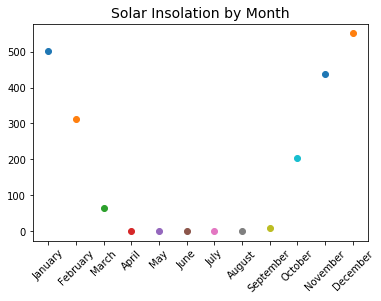

In [171]:
###plot solar insolation by month

fig, ax = plt.subplots(figsize = [6,4])
for m in np.array(ds['month']):
    plt.plot(m, ram_dict[.00038][m].subprocess.Radiation.insolation, 'o')
    plt.xticks(rotation = 45)
    plt.title('Solar Insolation by Month', fontsize = 14)